# Santander Value Prediction Challenge
    
The aim of this challenge: [Santander Value Prediction Challenge](https://www.kaggle.com/c/santander-value-prediction-challenge) is to predict the value of transactions for potential customers based on customer data provided by the Santander Bank. More specifically, the bank wants us to predict the “value of the customer’s transaction” before it occurs. The goal is to provide tailored financial service based on this prediction. 

**TABLE OF CONTENTS**

1. [Import the data ](#section1)

    
2. [Exploratory Data Analysis](#section2)

    2.1. [Analyze dataset: features/ data type/ missing value](#section11)
    
    2.2. [Visualize the data](#section22)
    
    
3. [Data Precessing](#section3)

    3.1. [Feature selection](#section31)
    
    3.2. [Add features](#section32)


4. [Model Building](#section4)

    4.1. [LightGBM](#section41)
    
    4.2. [XGB Modeling](#section42)
    
    4.3. [Catboost](#section42)
    

5. [Prediction](#section5)

# 1. Import the data

In [61]:
pip install catboost

     |████████████████████████████████| 10.9 MB 1.8 MB/s eta 0:00:01    |██████████████████████▋         | 7.7 MB 1.8 MB/s eta 0:00:02
     |████████████████████████████████| 12.9 MB 8.3 MB/s eta 0:00:01    |██▉                             | 1.1 MB 8.3 MB/s eta 0:00:02
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=507ea46e3834c266fe2a409ec3811e59d176a8e04d9c6499f2bc1ee0dca86d32
  Stored in directory: /Users/fy/Library/Caches/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
import gc #garbage collect--> release memory when delete something
gc.enable()
print(lgb.__version__)

2.3.0


In [4]:
def get_data():
    print('Reading data')
    data = pd.read_csv('train.csv', nrows=None) #get training data
    test = pd.read_csv('test.csv', nrows=None) #get testing data
    print('Train shape ', data.shape, ' Test shape ', test.shape)
    return data, test

# 2. Exploratory data analysis (EDA)

### 2.1 Analyze dataset: features/ data type/ missing value

In [5]:
train, test = get_data()

Reading data
Train shape  (4459, 4993)  Test shape  (49342, 4992)


In [6]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [8]:
train.isnull().values.any()

False


**Observations:**

1. we have 4459 rows in train set and 4993 columns in total including the target and id column. There are a LOT of features, Almost 5000 and they outnumber the number of rows in the training set.


2. There are less than 5000 training rows. In fact, there are fewer rows than columns, which means we'll have to invest a lot of effort into feature selection / feature engineering.


3. This work is going to test our ability to perform without relying on any domain knowledge and The results will be directly applicable to a real business problem. The column names are anonymized (we don't know the meaning of these columns) and we need to extract insights on customer value from this sparse anonymized tabular dataset.


4. Features seem sparse and there are many zero values present in the data,We'll have to investigate this further.


5. The memory size of the train dataset is fairly large - 170 MB, which is to be expected.


6. Pandas is treating 1845 features as float, and 3147 as integer. It is possible that some of those int features are one-hot-encoded or label-encoded categorical variables. We'll have to investigate this later


7. There doesn't appear to be any missing values in the train set. This is overall a good thing, although a lot of times there is some signal in the missing values that's valuable and worth exploring.

**Now let's take a look at the test dataset.**

In [9]:
test.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [11]:
test.isnull().values.any()

False

**Observations:**

1. Here we see that the number of features in the test set (4992) matches the number in the train set.



2. We also see that the number of rows in the test set far surpasses the number of rows in the train set. **Test set is almost 10 times as that of train set.**


3. According to Pandas, there are no int values in the test set. it is a little bit curious and need to be investigate later


4. There also doesn't seem to be any missing values in the test set.

**Now let's see some basic descriptive statistics for the train and test dataframes.**

In [12]:
train.describe()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,5.944923e+06,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,8.234312e+06,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.260000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+07,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


**Observation:**

1. Target variable ranges over 4 orders of magnitude. (factor of 10,000)


2. Most features have 0.0 for 75% - this is an indication that we are probably dealing with sparse data.


3. Most features seem to have similarly wide spread of values


4. The standard deviation for most features seems larger than the feature mean. 


5. There are a few features that seem to be filled with zeros. These will need to be eliminated.

**Now let's look at the test set.**

In [13]:
test.describe()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,...,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04,4.934200e+04
mean,5.773787e+04,6.258726e+04,1.036752e+05,6.289853e+04,6.713354e+04,8.083879e+04,6.181014e+04,5.515752e+04,1.406324e+06,8.128668e+04,...,1.193910e+05,1.355955e+05,3.242217e+05,1.437856e+05,9.302367e+04,8.047145e+04,6.076865e+04,1.323210e+05,1.675766e+05,1.282487e+05
std,1.745182e+06,2.322787e+06,2.586951e+06,2.765941e+06,3.206124e+06,2.845031e+06,2.780137e+06,1.923517e+06,6.872366e+06,2.378938e+06,...,3.115190e+06,2.598454e+06,3.782996e+06,3.663374e+06,5.041000e+06,2.100210e+06,2.040655e+06,3.592018e+06,3.761816e+06,2.413798e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.504447e+08,2.283295e+08,2.758171e+08,3.972621e+08,4.667591e+08,2.852223e+08,4.863751e+08,2.043290e+08,3.435658e+08,2.310167e+08,...,5.351692e+08,1.236547e+08,3.793398e+08,4.025480e+08,9.657530e+08,1.680065e+08,2.497913e+08,3.200000e+08,3.186300e+08,2.189782e+08


**Observation:**

We see a similar distribution of various statistical aggregates, but by no means the same: seems like there some substantial distribution shifts between the train and test sets. This will probably be another major concern when it comes to feature selection/engineering.

### 2.2 Visualize the data

**Now let's do some plotting. We'll take a look at, naturally, the target variable. First, let's make a scatter plot of its raw value.**

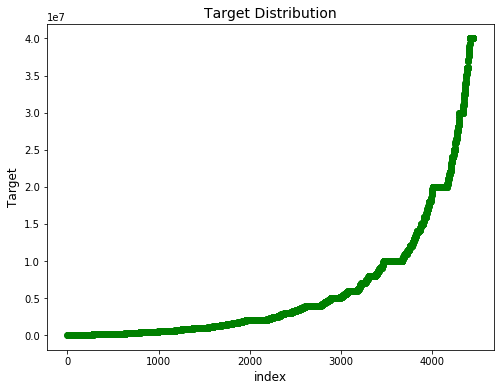

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['target'].values),color='g')
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

Looks like there are not any visible outliers in the data but the range is quite high.

We can now do a histogram plot of the target variable.

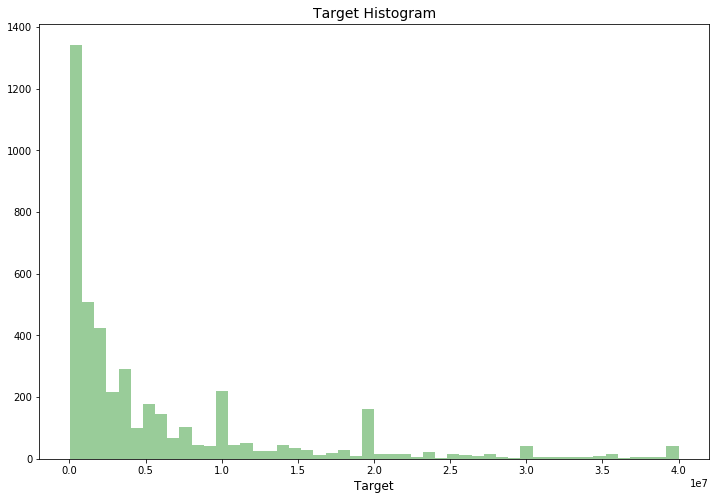

In [16]:
plt.figure(figsize=(12,8))
sns.distplot(train["target"].values, bins=50, kde=False,color='g')
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

This is a right skewed distribution with majority of the data points having low value. 

So let us do a histogram plot on the log of target variables and recheck again.

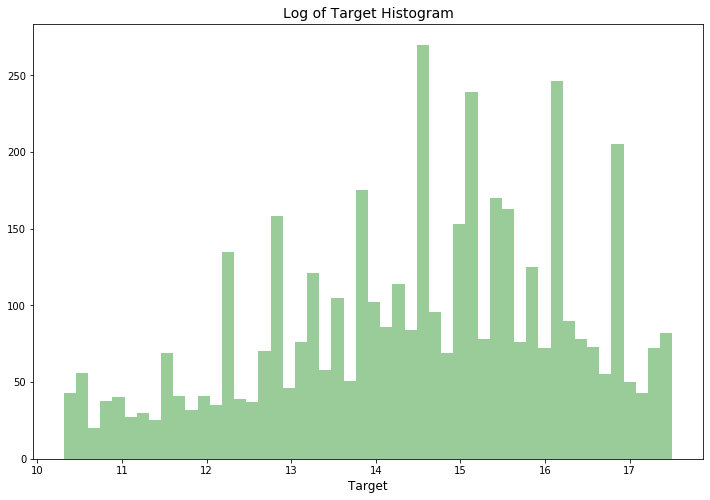

In [17]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train["target"].values), bins=50, kde=False,color='g')
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

As expected, this distribution looks much more normal. This is probably one of the main reasons why the metric that we are trying to optimize for this competition is RMSLE - root mean square logarithmic error.

Another way of looking at the same distribution is with the help of violinplot.

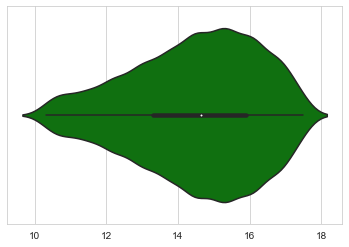

In [19]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=np.log(1+train.target.values),color='g')
plt.show()

It looks like a fairly nice distribution, albeit still fairly asymmetrical.

Let's take a look at the statistics of the Log(1+target)

In [20]:
train_log_target = train[['target']]
train_log_target['target'] = np.log(1+train['target'].values)
train_log_target.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,target
count,4459.000000
mean,14.490239
std,1.750947
min,10.308986
25%,13.304687
50%,14.630876
75%,15.894952
max,17.504390


We see that the statistical properties of the Log(1+Target) distribution are much more amenable.

Now let's take a look at columns with constant value.

In [31]:
constant_train = train.loc[:, (train == train.iloc[0]).all()].columns.tolist()
constant_test = test.loc[:, (test == test.iloc[0]).all()].columns.tolist()
print('Number of constant columns in the train set:', len(constant_train))
print('Number of constant columns in the test set:', len(constant_test))
print()
print('Probably it is a good idea to remove them from the training. Just printing out the names below for ease:')
print(constant_train)

Number of constant columns in the train set: 256
Number of constant columns in the test set: 0

Probably it is a good idea to remove them from the training. Just printing out the names below for ease:
['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8

So this is interesting: there are 256 constant columns in the train set, but none in the test set. These constant columns are thus most likely an artifact of the way that the train and test sets were constructed, and not necessarily irrelevant in their own right. This is yet another byproduct of having a very small dataset. For most problems it would be useful to take a look at the description of these columns, but in this work they are anonymized, and thus would not yield any useful information.

**Correlation of features with target:**

Now let us find the correlation of the variables with target and plot them.

we use Spearman correlation inplace of pearson here to find the relationship since spearman is computed on ranks and so depicts monotonic relationships while pearson is on true values and depicts linear relationships.


There are thousands of variables and so plotting all of them will give us a cluttered plot. So let us take only those variables whose absolute spearman correlation coefficient is more than 0.1 (just to reduce the number of variables) and plot them.

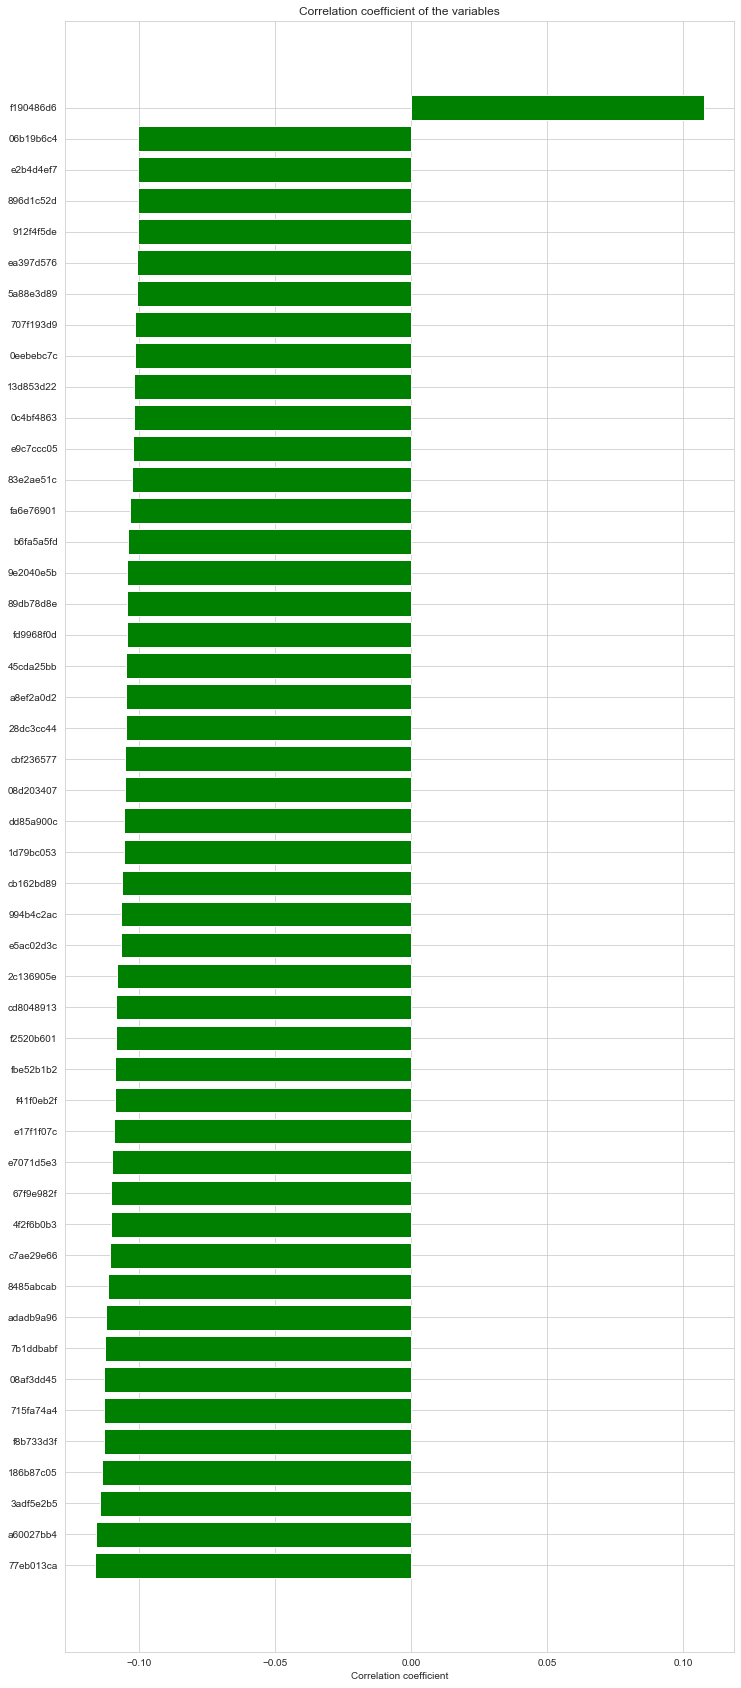

In [32]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []
for col in train.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train[col].values, train["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='g')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

There are quite a few variables with absolute correlation greater than 0.1

**Correlation Heat Map:**

Now let us take these variables whose absolute value of correlation with the target is greater than 0.1 (just to reduce the number of features) and do a correlation heat map.

This is just done to identify if there are any strong monotonic relationships between these important features. If the values are high, then probably we can choose to keep one of those variables in the model building process. we are doing this only for the very few features and we will add more features to explore more.

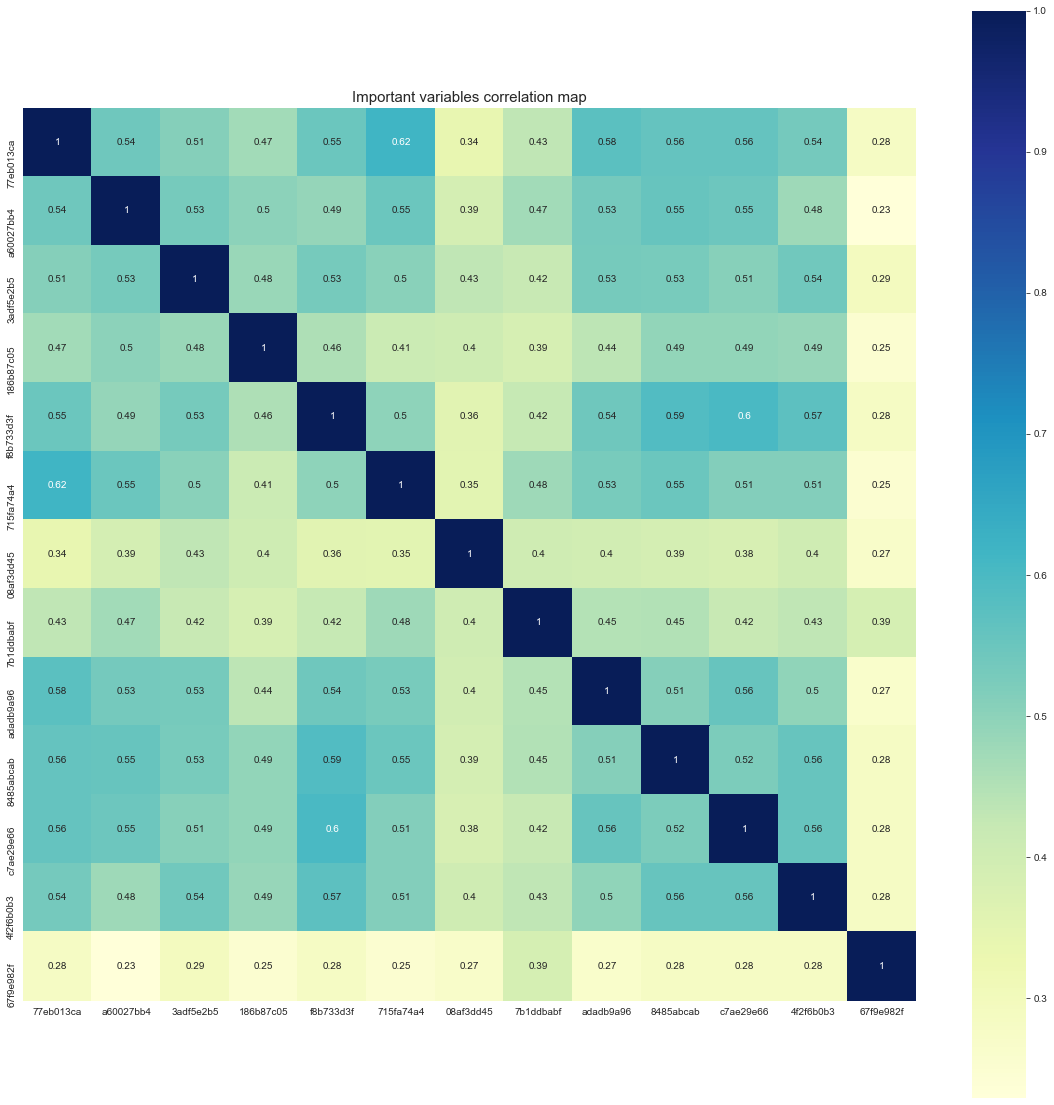

In [33]:
cols_to_use = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)].col_labels.tolist()

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

Seems like none of the selected variables have spearman correlation more than 0.7 with each other.

The above plots helped us in identifying the important individual variables which are correlated with target. 

# 3. Data Precessing

### 3.1 Feature selection

**Feature Importance - Extra trees model**

evaluation metric for this work is Root Mean Squared Logarithmic Error.The RMSLE is calculated as:
Where:

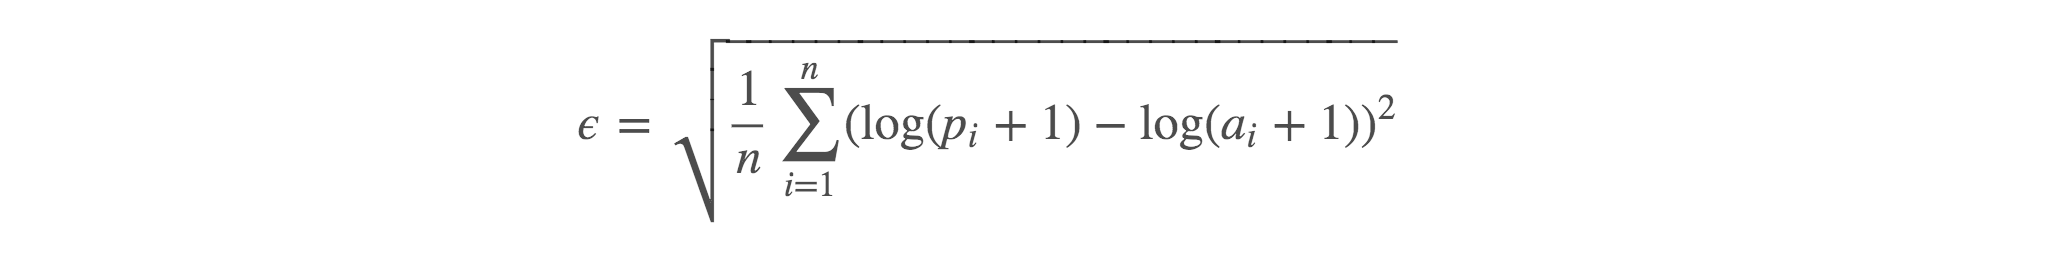

    (1) ϵ is the RMSLE value (score)
    (2) n is the total number of observations in the (public/private) data set,
    (3) pi is your prediction of target, and
    (4) ai is the actual target for i.
    (5) log(x) is the natural logarithm of x


So let us use log of the target variable to build our models. Also please note that we are removing those variables with constant values (that we identified earlier).

In [34]:
train_X = train.drop(constant_train + ["ID", "target"], axis=1)
test_X = train.drop(constant_train + ["ID"], axis=1)
train_y = np.log1p(train["target"].values)

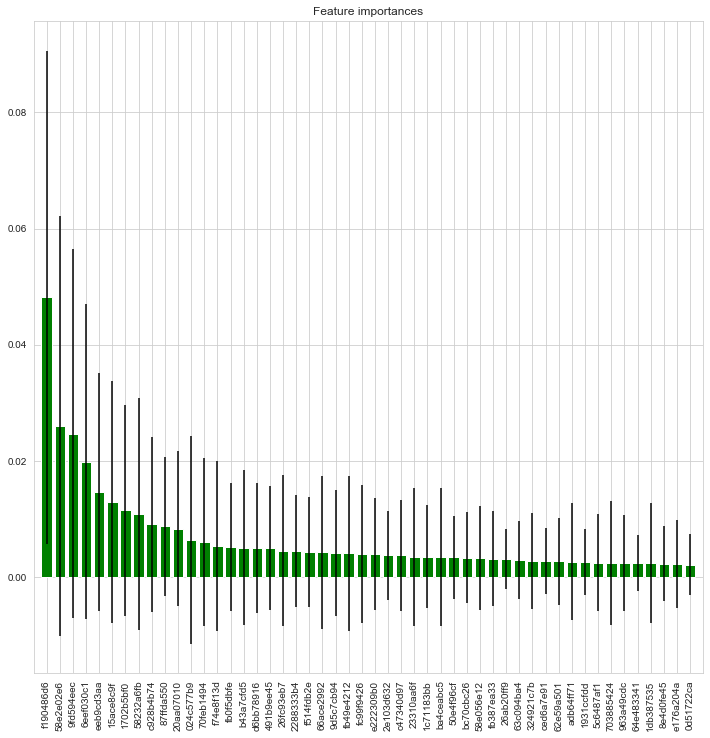

In [35]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:50]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

**Observation:**

1. It seems that the variable 'f190486d6' is the most important features that determine the value of the customer’s transaction

2. The latter variables are not very important according to the graph, and we only take the former 40 variables to analyze 

In [36]:
feat_names[indices][:40]

array(['f190486d6', '58e2e02e6', '9fd594eec', '6eef030c1', 'eeb9cd3aa',
       '15ace8c9f', '1702b5bf0', '58232a6fb', 'c928b4b74', '87ffda550',
       '20aa07010', '024c577b9', '70feb1494', 'f74e8f13d', 'fb0f5dbfe',
       'b43a7cfd5', 'd6bb78916', '491b9ee45', '26fc93eb7', '2288333b4',
       'f514fdb2e', '66ace2992', '9d5c7cb94', 'fb49e4212', 'fc99f9426',
       'e222309b0', '2e103d632', 'c47340d97', '23310aa6f', '1c71183bb',
       'ba4ceabc5', '50e4f96cf', 'bc70cbc26', '58e056e12', 'fb387ea33',
       '26ab20ff9', '63c094ba4', '324921c7b', 'ced6a7e91', '62e59a501'],
      dtype=object)

In [37]:
def get_selected_features():
    a=list(feat_names[indices][:40])
    return a

In [41]:
# Free some memory when del data['target'], data['ID'],test['ID']
gc.collect()

8263

### 3.2 Add features

In [72]:
def add_statistics(train_X, test_X):
    # This is part of the trick I think, models have a special process for NaNs
    # replace all the zero to NaNs
    train_X.replace(0, np.nan, inplace=True)
    test_X.replace(0, np.nan, inplace=True)
    
    original_features = [f for f in train_X]
    for df in [train_X, test_X]:
        df['nb_nans'] = df[original_features].isnull().sum(axis=1)#numebr of NaN in each row
        # All of the stats will be computed without the 0s 
        df['the_median'] = df[original_features].median(axis=1)#median of each row
        df['the_mean'] = df[original_features].mean(axis=1)#mean of  each row
        df['the_sum'] = df[original_features].sum(axis=1)#sum of each row
        df['the_std'] = df[original_features].std(axis=1)#standard deviation of each row
        df['the_kur'] = df[original_features].kurtosis(axis=1)#kurtosis of each row
        
    return train_X, test_X

In [49]:
train_X, test_X = add_statistics(train_X, test_X)
print(train_X, test_X)

      48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  30347e683  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
4454        NaN        NaN        NaN        NaN        NaN        NaN   
4455        NaN        NaN        NaN        NaN        NaN        NaN   
4456        NaN        NaN        NaN        NaN        NaN        NaN   
4457        NaN        NaN        NaN        NaN        NaN        NaN   
4458        NaN        NaN        NaN        NaN        NaN        NaN   

      d08d1fbe3  6ee66e115   20aa07010  dc5a8f1d8  ...  137efaa80  fb36b89d9  \
0           NaN        NaN     

In [79]:
features = get_selected_features() + ['nb_nans', 'the_median', 'the_mean', 'the_sum', 'the_std', 'the_kur']
train_X=train_X[features] 
test_X=test_X[features] 

In [74]:
dev_X, val_X, dev_y, val_y = train_test_split(train_X, train_y, test_size = 0.2, random_state = 42)

# 4. Model building

### 4.1 LightGBM

is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

    (1) Faster training speed and higher efficiency.
    (2) Lower memory usage.
    (3) Better accuracy.
    (4) Support of parallel and GPU learning.
    (5) Capable of handling large-scale data.

In [80]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=c)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result


In [81]:
# Training LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
print("LightGBM Training Completed")

Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.44435	valid_1's rmse: 1.46051
[300]	training's rmse: 1.2852	valid_1's rmse: 1.37495
[450]	training's rmse: 1.19425	valid_1's rmse: 1.34522
[600]	training's rmse: 1.1322	valid_1's rmse: 1.3369
Early stopping, best iteration is:
[629]	training's rmse: 1.12214	valid_1's rmse: 1.33657
LightGBM Training Completed


### 4.2 XGB Modeling

In [82]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb

In [83]:
# Training XGB
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, test_X)
print("XGB Training Completed.")

[0]	train-rmse:14.0876	valid-rmse:14.0768
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:12.7645	valid-rmse:12.7554
[200]	train-rmse:11.5687	valid-rmse:11.5612
[300]	train-rmse:10.488	valid-rmse:10.4817
[400]	train-rmse:9.51133	valid-rmse:9.50661
[500]	train-rmse:8.62932	valid-rmse:8.62552
[600]	train-rmse:7.8329	valid-rmse:7.83087
[700]	train-rmse:7.11406	valid-rmse:7.11407
[800]	train-rmse:6.46555	valid-rmse:6.46808
[900]	train-rmse:5.88074	valid-rmse:5.88638
[1000]	train-rmse:5.35391	valid-rmse:5.36309
[1100]	train-rmse:4.87931	valid-rmse:4.89285
[1200]	train-rmse:4.45205	valid-rmse:4.47101
[1300]	train-rmse:4.06745	valid-rmse:4.09259
[1400]	train-rmse:3.722	valid-rmse:3.75391
[1500]	train-rmse:3.41185	valid-rmse:3.45158
[1600]	train-rmse:3.13313	valid-rmse:3.18151
[1700]	train-rmse:2.88313	valid-rmse:2.94112
[1800]	train-rmse:2.65923	valid-rmse:2.72806
[1900]	train-rm

### 4.3 Catboost

In [84]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [85]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 1.7345692	test: 1.6718998	best: 1.6718998 (0)	total: 95.7ms	remaining: 47.8s
50:	learn: 1.2824994	test: 1.3673618	best: 1.3673618 (50)	total: 3.71s	remaining: 32.7s
100:	learn: 1.1716012	test: 1.3523203	best: 1.3521821 (99)	total: 7.13s	remaining: 28.2s
150:	learn: 1.0894129	test: 1.3494941	best: 1.3486330 (134)	total: 10.6s	remaining: 24.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.348632978
bestIteration = 134

Shrink model to first 135 iterations.


In [88]:
pred_test_cat = np.expm1(cb_model.predict(test_X))

**LightGBM:** valid rmse: 1.33657 

**XGB Modeling:** valid rmse: 2.37512

**Catboost:** valid rmse: 1.3486330

LightGBM has the minimum root mean squared error, we use LightGBM model to predict test target 

# 5. Prediction

In [99]:
prediction = pred_test
prediction=pd.DataFrame(prediction)
prediction.to_csv('prediction.csv', index=False)

In [101]:
prediction.head(20)

,0
0,5.352161e+06
1,1.249751e+06
2,4.447881e+06
3,1.392984e+06
4,5.220647e+06
5,2.978126e+06
6,1.852429e+05
7,2.673257e+06
8,1.680959e+06
9,8.557051e+05
